# Political Alignment and Outlook

This is the third in a series of notebooks that make up a [case study in exploratory data analysis](https://allendowney.github.io/PoliticalAlignmentCaseStudy/).
This case study is part of the [*Elements of Data Science*](https://allendowney.github.io/ElementsOfDataScience/) curriculum.

In the previous chapter, we used data from the General Social Survey (GSS) to plot changes in political alignment over time.

In this notebook, we explore the relationship between political alignment and questions related to "outlook", like:

* `happy`: Taken all together, how would you say things are these days--would you say that you are very happy, pretty happy, or not too happy?

* `trust`: Generally speaking, would you say that most people can be trusted or that you can't be too careful in dealing with people?

* `helpful`: Would you say that most of the time people try to be helpful, or that they are mostly just looking out for themselves?

* `fair`: Do you think most people would try to take advantage of you if they got a chance, or would they try to be fair?

As an example, I'll look at `fair`, and then as an exercise you can look at one of the others.

1. First we'll use `groupby` to compare the average response between groups and plot the average as a function of time.

2. We'll use the Pandas function `pivot table` to compute the average response within each group as a function of time.

3. And we'll use resampling to see whether the features we see in the figures might be due to randomness, or whether they are likely to reflect actual changes in the works.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
def values(series):
    """Count the values and sort.
    
    series: pd.Series
    
    returns: series mapping from values to frequencies
    """
    return series.value_counts().sort_index()

In [15]:
def decorate(**options):
    """Decorate the current axes.
    
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
             
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)
    
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

In [16]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def make_lowess(series):
    """Use LOWESS to compute a smooth line.
    
    series: pd.Series
    
    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index) 

In [17]:
def plot_series_lowess(series, color):
    """Plots a series of data points and a smooth line.
    
    series: pd.Series
    color: string or tuple
    """
    series.plot(linewidth=0, marker='o', color=color, alpha=0.5)
    smooth = make_lowess(series)
    smooth.plot(label='_', color=color)

In [18]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/' +
         'raw/update2021/gss_eds.3.hdf5')

In [19]:
datafile = 'gss_eds.3.hdf5'
gss = pd.read_hdf(datafile, 'gss0')
gss.shape

(68846, 204)

## Are People Fair?

In the GSS data, the variable `fair` contains responses to this question (see <https://gssdataexplorer.norc.org/projects/52787/variables/440/vshow>):

> Do you think most people would try to take advantage of you if they got a chance, or would they try to be fair?

The possible responses are:

```
1	Take advantage
2	Fair
3	Depends
```

As always, we start by looking at the distribution of responses, that is, how many people give each response:

In [20]:
values(gss['fair'])

1.0    15435
2.0    22806
3.0     2755
Name: fair, dtype: int64

Let's also check how many values are missing.

In [21]:
# Solution

gss['fair'].isna().sum()

27850

And recode to select people who give the affirmative response.

In [22]:
# Solution

recode_fair = {1:0, 2:1, 3:0}

In [23]:
# Solution

gss['fair2'] = gss['fair'].replace(recode_fair)

In [24]:
# Solution

values(gss['fair2'])

0.0    18190
1.0    22806
Name: fair2, dtype: int64

## Fairness Over Time

We'll use `groupby` to compute the fraction of affirmative responses over time.

In [25]:
# Solution

gss_by_year = gss.groupby('year')
for name, group in gss_by_year:
    print(name, len(group))

1972 1613
1973 1504
1974 1484
1975 1490
1976 1499
1977 1530
1978 1532
1980 1468
1982 1860
1983 1599
1984 1473
1985 1534
1986 1470
1987 1819
1988 1481
1989 1537
1990 1372
1991 1517
1993 1606
1994 2992
1996 2904
1998 2832
2000 2817
2002 2765
2004 2812
2006 4510
2008 2023
2010 2044
2012 1974
2014 2538
2016 2867
2018 2348
2021 4032


In [26]:
# Solution

fair_by_year = gss_by_year['fair2'].mean()

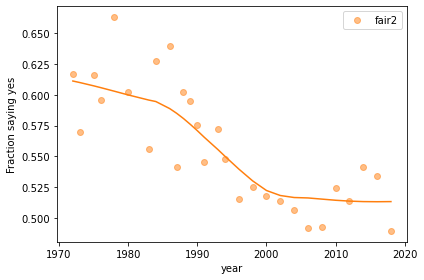

In [27]:
# Solution

plot_series_lowess(fair_by_year, 'C1')

decorate(ylabel='Fraction saying yes')

## Political Views on a 3-point Scale

In the previous notebook, we looked at responses to `polviews`, which asks about political alignment.  The valid responses are:

```
1	Extremely liberal
2	Liberal
3	Slightly liberal
4	Moderate
5	Slightly conservative
6	Conservative
7	Extremely conservative
```

To make it easier to visualize groups, I'm going to lump the 7-point scale into a 3-point scale.

In [28]:
recode_polviews = {1:'Liberal', 
                   2:'Liberal', 
                   3:'Liberal', 
                   4:'Moderate', 
                   5:'Conservative', 
                   6:'Conservative', 
                   7:'Conservative'}

In [29]:
gss['polviews3'] = gss['polviews'].replace(recode_polviews)

In [30]:
values(gss['polviews3'])

Conservative    20359
Liberal         16195
Moderate        22950
Name: polviews3, dtype: int64

## Fairness by Group

Now let's group by `polviews` and compute the fraction of affirmative responses in each group.

In [32]:
# Solution

gss_by_polviews = gss.groupby('polviews3')
for name, group in gss_by_polviews:
    print(name, len(group))

Conservative 20359
Liberal 16195
Moderate 22950


In [33]:
# Solution

gss_by_polviews['fair2'].mean()

polviews3
Conservative    0.582789
Liberal         0.553916
Moderate        0.542407
Name: fair2, dtype: float32

<AxesSubplot:xlabel='polviews3'>

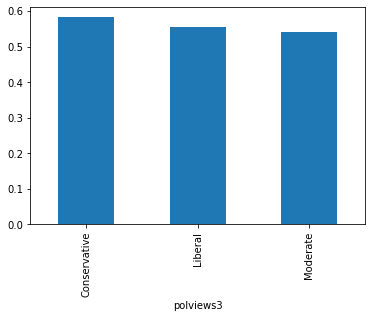

In [34]:
# Solution

gss_by_polviews['fair2'].mean().plot(kind='bar')

## Fairness over Time by Group

So far, we have grouped by `polviews3` and computed the mean of `fair2` in each group.
Then we grouped by `year` and computed the mean of `fair2` for each year.
Now I want to group by `polviews3` and `year`, and compute the mean of `fair2` in each group over time.

We could do the computation I just described "by hand" using the tools we already have, but it is so common and useful that it has a name: it is called a **pivot table**, and Pandas provides a function that computes it (see <https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html>).

It's called `pivot_table`, and it takes the following arguments:

* `values`, which is the name of the variable we want to summarize: `fair2` in this example.

* `index`, which is the name of the variable that will provide the row labels: `year` in this example.

* `columns`, which is the name of the variable that will provide the column labels: `polview3` in this example.

* `aggfunc`, which is the function used to "aggregate", or summarize, the values: `mean` in this example.

In [43]:
# Solution

table = gss.pivot_table(values='fair2', 
                        index='year', 
                        columns='polviews3', 
                        aggfunc='mean')

In [44]:
# Solution

table.head()

polviews3,Conservative,Liberal,Moderate
year,,,
1975,0.625616,0.617117,0.647280
1976,0.631696,0.571782,0.612100
1978,0.694915,0.659420,0.665455
1980,0.600000,0.554945,0.640264
1983,0.572438,0.585366,0.463492


## Plotting the Results

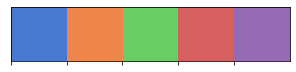

In [45]:
muted = sns.color_palette('muted', 5)
sns.palplot(muted)

In [46]:
color_map = {'Conservative': muted[3], 
              'Moderate': muted[4], 
               'Liberal': muted[0]}

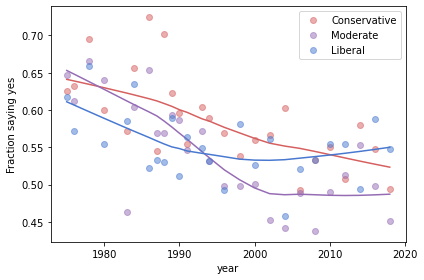

In [47]:
# Solution

for name in color_map:
    plot_series_lowess(table[name], color_map[name])

decorate(ylabel='Fraction saying yes')

## Simulating Possible Datasets

In [48]:
def plot_by_polviews(gss):
    """Plot mean response by polviews and year.
    
    gss: DataFrame
    """
    gss['polviews3'] = gss['polviews'].replace(recode_polviews)
    gss['fair2'] = gss['fair'].replace(recode_fair)
    
    table = gss.pivot_table(values='fair2', 
                        index='year', 
                        columns='polviews3', 
                        aggfunc='mean')

    for name in color_map:
        plot_series_lowess(table[name], color_map[name])

    decorate(ylabel='Fraction saying yes')

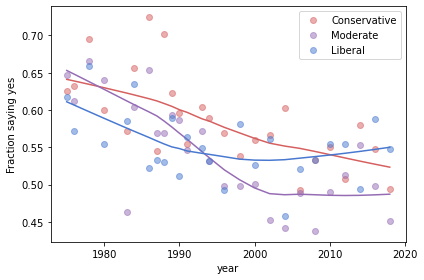

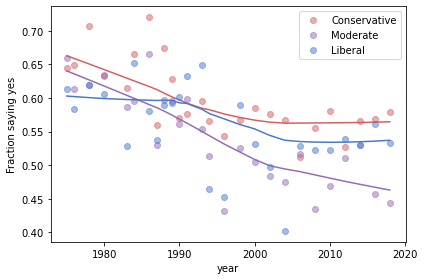

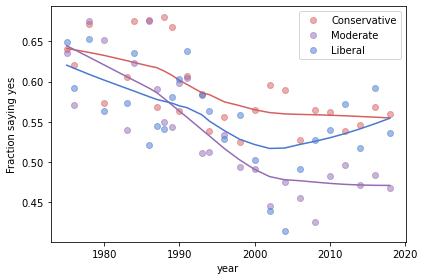

In [49]:
for key in ['gss0', 'gss1', 'gss2']:
    df = pd.read_hdf('gss_eda.3.hdf5', key)

    plt.figure()
    plot_by_polviews(df)

**Exercise:** As an exercise, you can run the same analysis with one of the other variables related to outlook including `happy`, `trust`, `helpful`, and maybe `fear` and `hapmar`.

For these variables, you will have to read the codebook to see the responses and how they are encoded, then think about which responses to report.

Here are the steps I suggest:
    
1) If you have not already saved this notebook, you might want to do that first. If you are running on Colab, select "Save a copy in Drive" from the File menu.

2) Now, before you modify this notebook, make another copy and give it an appropriate name.

3) Search and replace `fair` with the name of the variable you select (use "Edit->Find and replace").

4) Run the notebook from the beginning and see what other changes you have to make.


Political Alignment Case Study

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)